In [138]:
#import Pkg; Pkg.add("...")

using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux, ForwardDiff
using Plots
gr()

Plots.GRBackend()

## Generate the (noisy) training dataset from:


## $$
\begin{aligned}
  \dot{q} &= \frac{1}{m l^{2}}p \\
  \dot{p} &=  -m l sin(q)
\end{aligned}
$$


In [2]:
H(q, p, m, l) = norm(p)^2/(2*m*l) - m*l*cos(norm(q))
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-H(q, p, params[1], params[2]), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> H(q, p, params[1], params[2]), p)

solvealg = Ruth3()

N = 50
TDataset = []
u0s = []
p_ = Float32[1., 1.]
tspan = (0.0f0, 3.0f0)
dt = 1//20


for i ∈ 1:N
    u0 = Float32[rand((1,-1))*rand()*π, rand((1,-1))*rand()*π]
    u0s = push!(u0s, [[u0[1]],[u0[2]]])
    
    prob = DynamicalODEProblem(pdot, qdot, [u0[1]], [u0[2]], tspan, p_)
    sol = solve(prob, solvealg, dt=dt)

    X = Array(sol)
    # Add noise to the data
    #println("trajectory $i")
    Xₙ = X + Float32(1e-3)*randn(eltype(X), size(X))
    
    TDataset = push!(TDataset, Xₙ)
end

TDataset;
u0s;

UndefVarError: UndefVarError: Ruth3 not defined

## Plot the training dataset

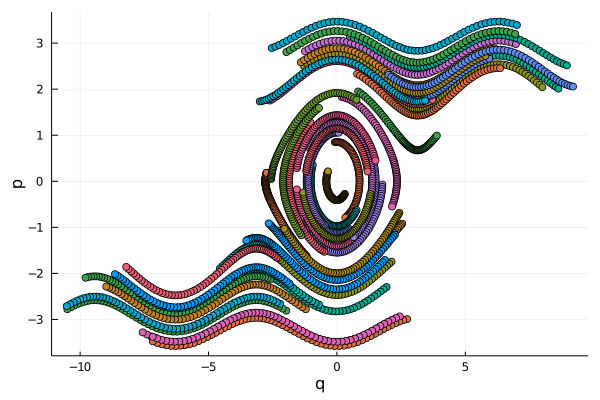

In [345]:
scatter(TDataset[1][2, :], TDataset[1][1, :], label = "", xlabel = "q", ylabel = "p")
for i ∈ 1:(N-1)
    scatter!(TDataset[i][2, :], TDataset[i][1, :], label = "", xlabel = "q", ylabel = "p")
end
scatter!(TDataset[N][2, :], TDataset[N][1, :], label = "", xlabel = "q", ylabel = "p")

### UADE

## $$
\begin{aligned}
  \dot{q} &=  K_{\theta}(p) \\
  \dot{p} &=  -V_{\theta}(q) 
\end{aligned}
$$

In [364]:
# Neural network
solvealg = Ruth3()

K = FastChain(FastDense(1, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 1))
V = FastChain(FastDense(1, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 1))
pₖ = initial_params(K)
pᵥ = initial_params(V)

H(q, p, pₖ, pᵥ) = K(p[1], pₖ)[1] - V(q[1], pᵥ)[1]
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-H(q, p, params[1], params[2]), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> H(q, p, params[1], params[2]), p)

#pdot(dp,p,q,params,t) = K(q, pₖ)[1]
#qdot(dq,p,q,params,t) = - V(p, pᵥ)[1]
#pdot(dp,p,q,params,t) = -sin.(q)
#qdot(dq,p,q,params,t) = p./2

qdot (generic function with 1 method)

## Plot the untrained solution

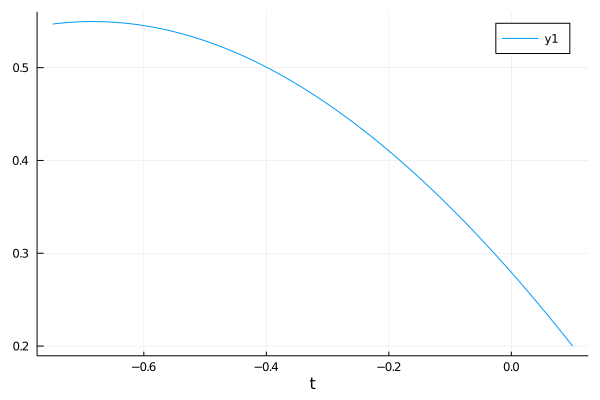

In [365]:
initial_position = [.1]
initial_velocity = [0.2]
prob = DynamicalODEProblem(pdot, qdot, initial_position, initial_velocity, tspan, [pₖ, pᵥ])
sol = solve(prob, solvealg, dt=dt)
plot(sol[1,:], sol[2,:], xlabel = "t")

## Loss function

In [377]:
# This function is used in the loss
function predict(θ, u0)
    prob = DynamicalODEProblem(pdot, qdot, u0[1], u0[2], tspan, θ);
    Array(solve(prob, solvealg, dt=dt))
end

function loss(θ)
    loss = 0
    for i ∈ 1:N
        pred = predict(θ, u0s[i])
        loss = loss + sum(abs2, TDataset[i] .- pred)
    end
    loss
end

# Test
#loss(p)
const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%50==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

In [1]:
TDataset[1]

UndefVarError: UndefVarError: TDataset not defined

## Training with ADAM

In [383]:
res1 = DiffEqFlux.sciml_train(loss, [pₖ, pᵥ], ADAM(0.01), cb=callback, maxiters = 10)

MethodError: MethodError: no method matching typemax(::Type{Array{Float32,1}})
Closest candidates are:
  typemax(!Matched::Type{Bool}) at bool.jl:7
  typemax(!Matched::Type{Int8}) at int.jl:652
  typemax(!Matched::Type{UInt8}) at int.jl:654
  ...

## Training with BFGS

In [115]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 100)

 * Status: failure

 * Candidate solution
    Final objective value:     4.479349e+01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 8.29e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.27e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.32e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.64e-02 ≰ 0.0e+00
    |g(x)|                 = 1.06e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   411  (vs limit Inf)
    Iterations:    31
    f(x) calls:    100
    ∇f(x) calls:   100


## Plot the loss

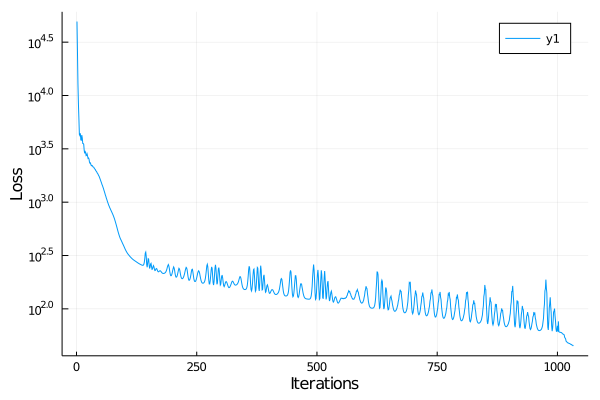

In [116]:
plot(losses, yaxis=:log, xlabel = "Iterations", ylabel = "Loss")

## Plot the approximation and the original data

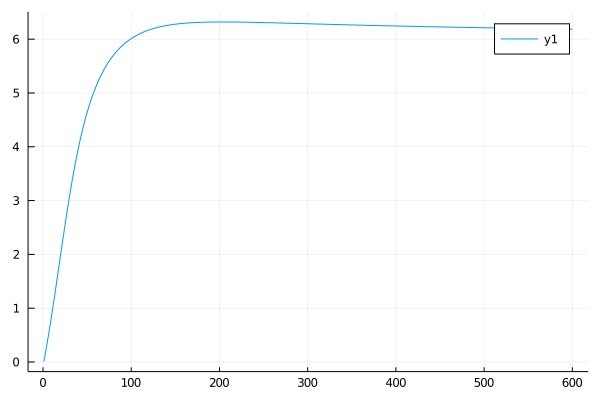

In [105]:
V = []

for i in 1:600
    v = push!(V, L([1,i*0.1],res2.minimizer)[1])
end

plot(V)

## Prediction

In [117]:
function Pendulum_trained(u, p, t)
    z = L(u,p)
    [z[1],
    -z[2]]
end

# ODE problem
tspan2 = (0.0f0, 5.0f0)
prob_nn2 = ODEProblem(Pendulum_trained, u0s[2], tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, solvealg, saveat = saveat);

## Test the prediction

In [118]:
tspan_test = tspan2
p_ = Float32[1., 1.]
prob_test = ODEProblem(Pendulum, u0s[2], tspan_test, p_)
solution_test = solve(prob_test, solvealg, saveat = saveat);

## Plot Toghether True And Prediction
### Phase Space Plot

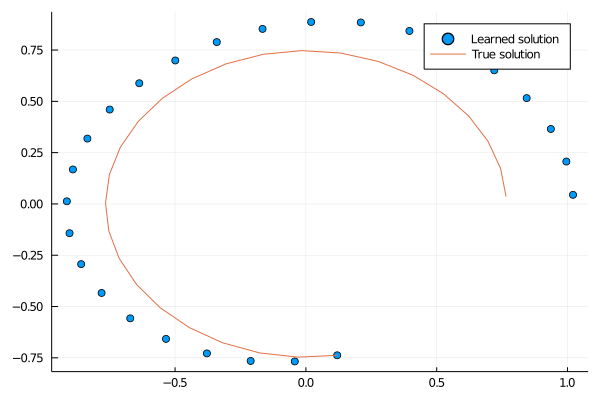

In [119]:
#scatter(Array(solution_test)[1, :], Array(solution_test)[2, :])
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :], label = "Learned solution")
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :], label = "True solution")

## Plot $x(t)$ and $y(t)$

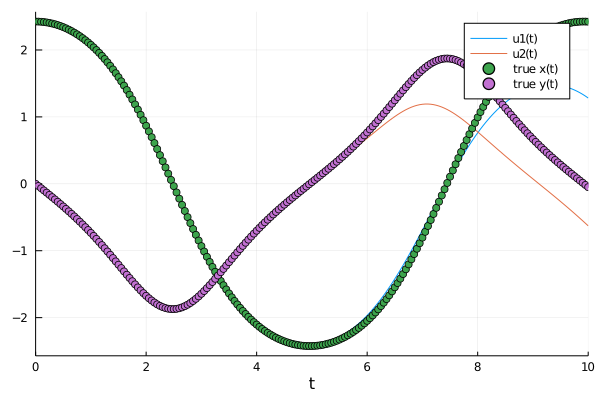

In [71]:
plot(sol_nn2)
scatter!(solution_test.t, Array(solution_test)[1, :], label = "true x(t)")
scatter!(solution_test.t, Array(solution_test)[2, :], label = "true y(t)")

---------------------------------------------------
---------------------------------------------------
---------------------------------------------------

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives

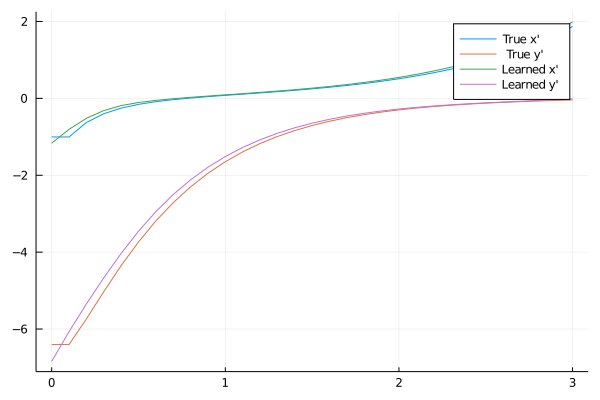

In [15]:
DX = Array(solution(solution.t, Val{1}))

prob_nn2 = ODEProblem(dudt_, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())
DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["True x'" " True y'"])
plot!(solution.t, DX_', label = ["Learned x'" "Learned y'"])

## The learned derivatives

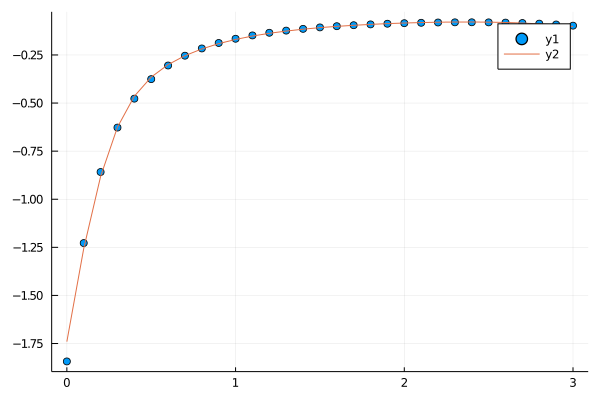

In [16]:
# Ideal data
L̄ = [-p_[2]*(X[1,:].*X[2,:])';p_[3]*(X[1,:].*X[2,:])']
# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

scatter(solution.t, L̄'[:, 1])
plot!(solution.t, L̂'[:, 1])

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

## Create a basis for the sparse identification

In [17]:
@variables u[1:2]

# Lots of polynomials
polys = Operation[1]

for i ∈ 1:5
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:5
        if i != j
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; polys...]
basis = Basis(h, u)

29 dimensional basis in ["u₁", "u₂"]

## Optimizer for the SINDy problem

In [18]:
opt = SR3()

# Create the thresholds which should be used in the search process
λ = exp10.(-7:0.1:3)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge (fail)

In [19]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 10000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 4
Active terms : 4
   Equation 1 : 3
   Equation 2 : 1
Overall error (L2-Norm) : 3.3763685
   Equation 1 : 1.9535239
   Equation 2 : 1.4228446
AICC :
   Equation 1 : 4.859922
   Equation 2 : 1.0179385

SR3{Float64,UnionAll}(0.3154786722400966, 1.0, ProximalOperators.NormL1) converged after 380 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = sin(u₁) * p₂ + cos(u₂) * p₁ + u₁ ^ 2 * p₃
du₂ = p₄ * u₂



## Test on UADE derivative data

In [20]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 10000, normalize = true, denoise = true) # Succeed
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 2
Active terms : 2
   Equation 1 : 1
   Equation 2 : 1
Overall error (L2-Norm) : 0.19815874
   Equation 1 : 0.07996562
   Equation 2 : 0.11819312
AICC :
   Equation 1 : 12.549078
   Equation 2 : 10.986186

SR3{Float64,UnionAll}(0.019905358527674864, 1.0, ProximalOperators.NormL1) converged after 7442 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = p₁ * u₁ * u₂
du₂ = p₂ * u₁ * u₂



## Extract the parameter

In [21]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[-0.8765631, 0.7597578]


## Define the ODE with the new identified unknown term

In [22]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys);

In [23]:
function dudt(du, u, p, t)
    # Add SINDy Term
    α, δ, β, γ = p
    z = unknown_eq(u, [β; γ], t)
    du[1] = α*u[1] + z[1]
    du[2] = -δ*u[2] + z[2]
end

dudt (generic function with 1 method)

## Create the approximated problem and solution

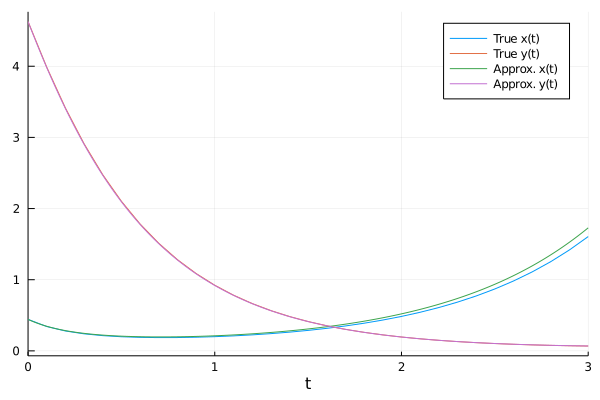

In [24]:
ps = [p_[[1,4]]; p̂]
approximate_prob = ODEProblem(dudt, u0, tspan, ps)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.01)

# Plot
plot(solution, label = ["True x(t)" "True y(t)"])
plot!(approximate_solution, label = ["Approx. x(t)" "Approx. y(t)"])

## Look at long term prediction

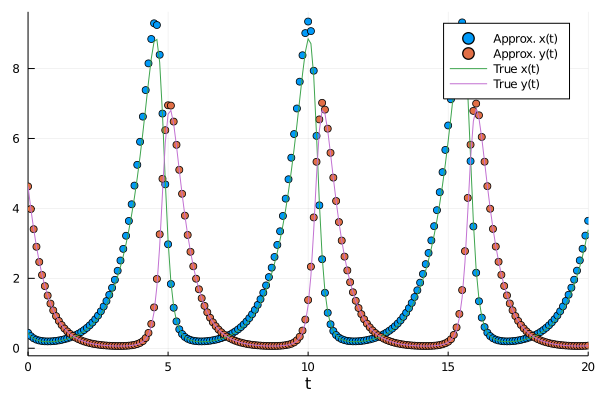

In [25]:
t_long = (0.0, 20.0)
approximate_prob = ODEProblem(dudt, u0, t_long, ps)
approximate_solution_long = solve(approximate_prob, Tsit5(), saveat = 0.1) # Using higher tolerances here results in exit of julia
scatter(approximate_solution_long, label = ["Approx. x(t)" "Approx. y(t)"])

true_prob = ODEProblem(LV, u0, t_long, p_)
true_solution_long = solve(true_prob, Tsit5(), saveat = approximate_solution_long.t)
plot!(true_solution_long, label = ["True x(t)" "True y(t)"])

--------------------------------------------
--------------------------------------------
--------------------------------------------

## How Sparse Identification work, simple example
########################################################

In [27]:
using DataDrivenDiffEq
using ModelingToolkit
using OrdinaryDiffEq

using LinearAlgebra
using Plots
gr()

# Create a test problem
function lorenz(u,p,t)
    x, y, z = u
    ẋ = 10.0*(y - x)
    ẏ = x*(28.0-z) - y
    ż = x*y - (8/3)*z
    return [ẋ, ẏ, ż]
end

u0 = [-8.0; 7.0; 27.0]
p = [10.0; -10.0; 28.0; -1.0; -1.0; 1.0; -8/3]

tspan = (0.0,100.0)

dt = 0.001

problem = ODEProblem(lorenz,u0,tspan)
solution = solve(problem, Tsit5(), saveat = dt, atol = 1e-7, rtol = 1e-8)

X = Array(solution)
DX = similar(X)
for (i, xi) in enumerate(eachcol(X))
    DX[:,i] = lorenz(xi, [], 0.0)
end

## Now automatically discover the system that generated the data
################################################################

In [28]:
@variables x y z
u = Operation[x; y; z]
polys = Operation[]

for i ∈ 0:4
    for j ∈ 0:i
        for k ∈ 0:j
            push!(polys, u[1]^i*u[2]^j*u[3]^k)
            push!(polys, u[2]^i*u[3]^j*u[1]^k)
            push!(polys, u[3]^i*u[1]^j*u[2]^k)
        end
    end
end

basis = Basis(polys, u)

opt = STRRidge(0.1)
Ψ = SINDy(X, DX, basis, opt, maxiter = 100, normalize = true)
println(Ψ)
print_equations(Ψ)
get_error(Ψ)

Sparse Identification Result
No. of Parameters : 7
Active terms : 7
   Equation 1 : 2
   Equation 2 : 3
   Equation 3 : 2
Overall error (L2-Norm) : 5.465109513295757e-11
   Equation 1 : 6.7202639134663155e-12
   Equation 2 : 3.505423292198665e-11
   Equation 3 : 1.2876598297504605e-11
AICC :
   Equation 1 : 106.90381476450982
   Equation 2 : 102.29689898255064
   Equation 3 : 104.30267815708592

STRRidge{Float64}(0.1) converged after 2 iterations.

3 dimensional basis in ["x", "y", "z"]
dx = p₁ * x + p₂ * y
dy = p₃ * x + p₄ * y + p₅ * x * z
dz = p₆ * z + p₇ * x * y



3-element Array{Float64,1}:
 6.7202639134663155e-12
 3.505423292198665e-11
 1.2876598297504605e-11